In [ ]:
import os
import pickle
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

In [2]:
def load_pickle_data(pkl_path):
    """Load and return data from a pickle file."""
    if not os.path.exists(pkl_path):
        print(f"[ERROR] Pickle file not found: {pkl_path}")
        return {}
    with open(pkl_path, "rb") as f:
        data = pickle.load(f)
    print(f"[SUCCESS] Loaded data from {pkl_path}")
    return data

In [3]:
DAILY_PKL = os.path.join("temp_output", "daily_X_y.pkl")
QUARTERLY_PKL = os.path.join("temp_output", "quarterly_X_y.pkl")

daily_data_dict = load_pickle_data(DAILY_PKL)
quarterly_data_dict = load_pickle_data(QUARTERLY_PKL)

[SUCCESS] Loaded data from temp_output/daily_X_y.pkl
[SUCCESS] Loaded data from temp_output/quarterly_X_y.pkl


In [4]:
daily_data_dict.keys()

dict_keys(['AAPL', 'MSFT', 'LLY', 'UNH', 'V', 'MA', 'GOOGL', 'META', 'AMZN', 'TSLA', 'PG', 'WMT', 'RTX', 'UNP', 'XOM', 'CVX', 'LIN', 'SHW', 'AMT', 'PLD', 'NEE', 'SO', '^GSPC'])

In [71]:
# Assume MODEL_TYPES is defined as:
MODEL_TYPES = ['RF', 'SVM', 'GB', 'XGB']
#MODEL_TYPES = ['MLP', 'RNN', 'LSTM', 'GRU']
LOG_DIR_HEAD = "model_logs_"
#LOG_DIR_HEAD = "model_dl_logs_"
MAX_CONFIGS = 32

def combine_and_top_logs(log_dir="model_logs", tops=5):
    all_files = [os.path.join(log_dir, f) for f in os.listdir(log_dir) if f.endswith(".csv")]
    dfs = [pd.read_csv(f) for f in all_files]
    combined_logs = pd.concat(dfs, ignore_index=True)
    
    grouped_summary = combined_logs.groupby(
        ["model_name", "model_hyperparameters_dict"]
    )[["MSE_score", "MAPE_score", "R^2_score"]].mean().reset_index()
    
    top_n_list = []
    for model in grouped_summary["model_name"].unique():
        top_n = grouped_summary[grouped_summary["model_name"] == model].sort_values("MAPE_score", ascending=True).head(tops)
        top_n_list.append(top_n)
        
    top_n_combined = pd.concat(top_n_list, ignore_index=True)
    return top_n_combined

# Load top logs from quarterly and daily directories.
top_summary_q = combine_and_top_logs(log_dir=f"{LOG_DIR_HEAD}q", tops=MAX_CONFIGS)
top_summary_d = combine_and_top_logs(log_dir=f"{LOG_DIR_HEAD}d", tops=MAX_CONFIGS)

# Label each log summary by range.
top_summary_q["range"] = "q"
top_summary_d["range"] = "d"

# Merge both summaries.
combined_top_summary = pd.concat([top_summary_q, top_summary_d], ignore_index=True)

# Create a dictionary to store the results DataFrame for each model type.
results_dict = {}

for model in MODEL_TYPES:
    model_rows = combined_top_summary[combined_top_summary["model_name"] == model].copy()
    
    # Parse the JSON hyperparameter strings.
    model_rows["hyperparams"] = model_rows["model_hyperparameters_dict"].apply(json.loads)
    model_rows = model_rows.reset_index(drop=True)
    
    # Flatten the parsed hyperparameters into columns.
    hyperparam_df = pd.json_normalize(model_rows["hyperparams"])
    
    # Concatenate the flattened columns with the original DataFrame.
    model_results = pd.concat([model_rows, hyperparam_df], axis=1)
    
    # Drop the original JSON column and temporary hyperparams column.
    model_results = model_results.drop(columns=["model_hyperparameters_dict", "hyperparams"])
    
    # Sort the DataFrame by MAPE_score.
    model_results = model_results.sort_values("MAPE_score").reset_index(drop=True)
    
    # Save to a CSV file (e.g., "SVM_results.csv", "RF_results.csv", etc.)
    output_csv = f"temp_output/{model}_results.csv"
    model_results.to_csv(output_csv, index=False)
    print(f"[SUCCESS] Saved {output_csv}")
    
    # Store the DataFrame in the results dictionary.
    results_dict[model] = model_results

[SUCCESS] Saved temp_output/RF_results.csv
[SUCCESS] Saved temp_output/SVM_results.csv
[SUCCESS] Saved temp_output/GB_results.csv
[SUCCESS] Saved temp_output/XGB_results.csv


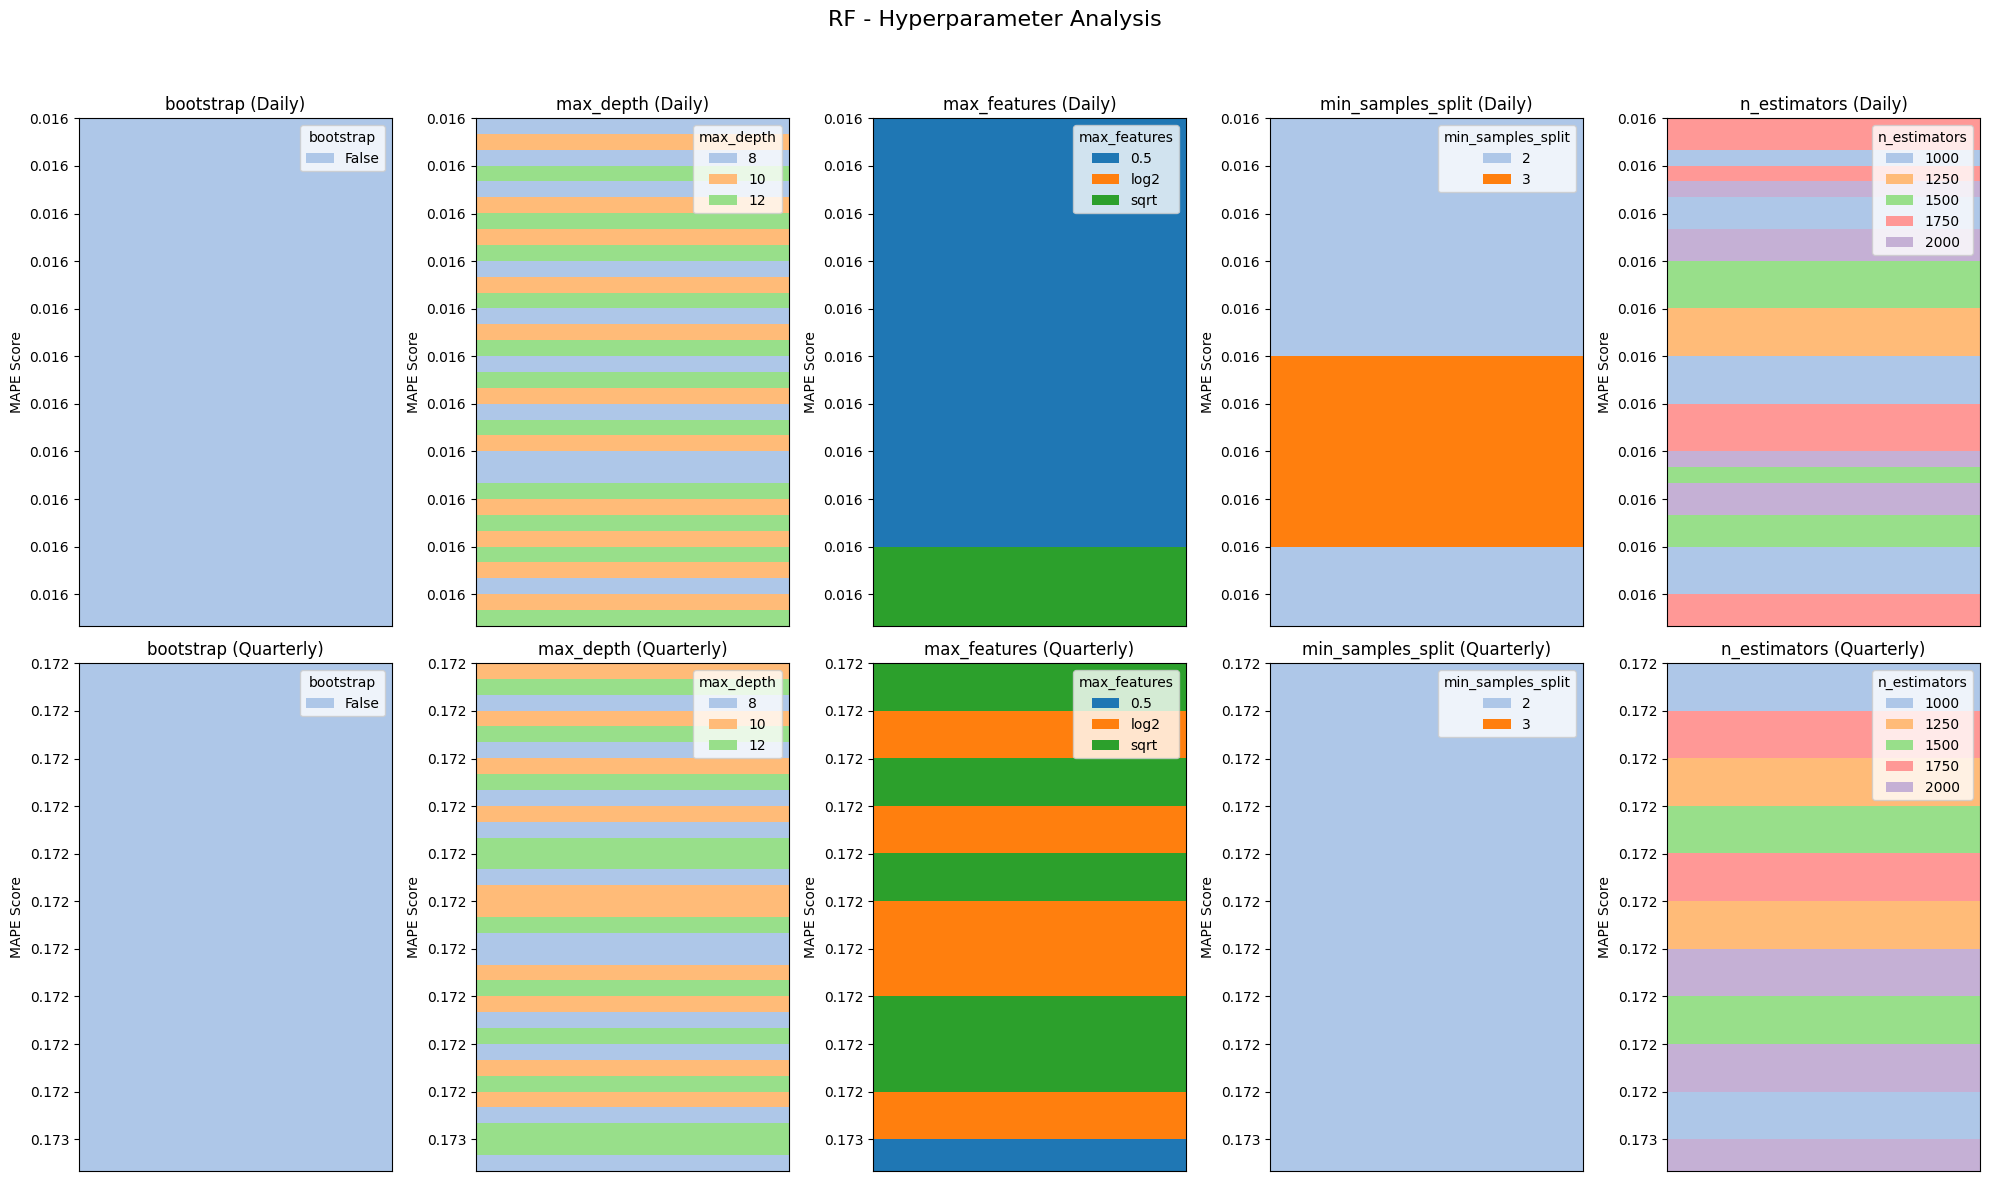

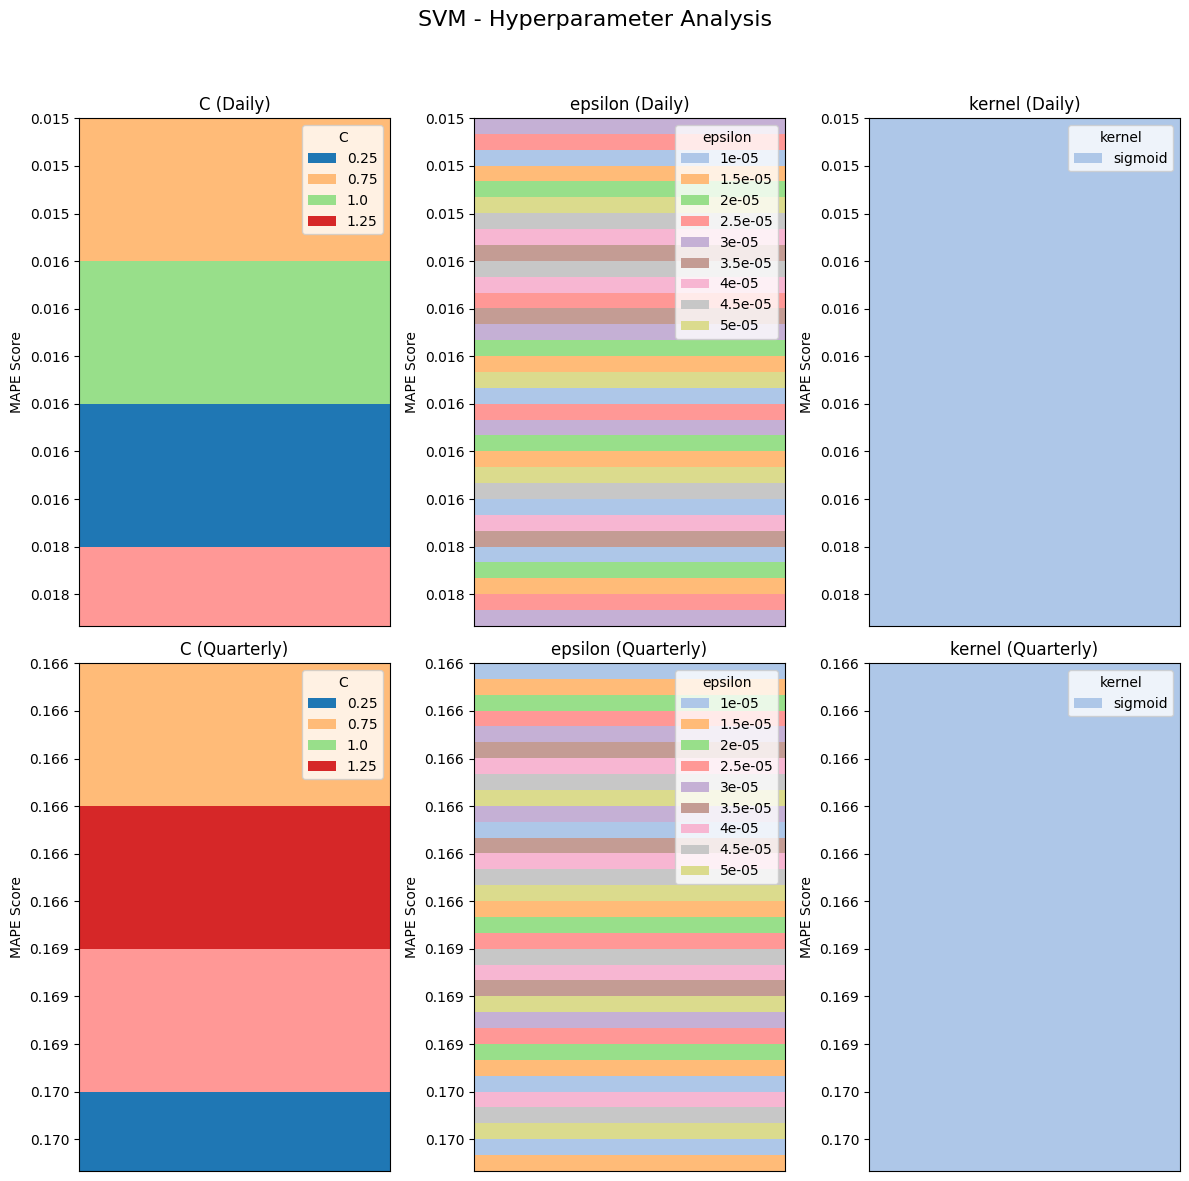

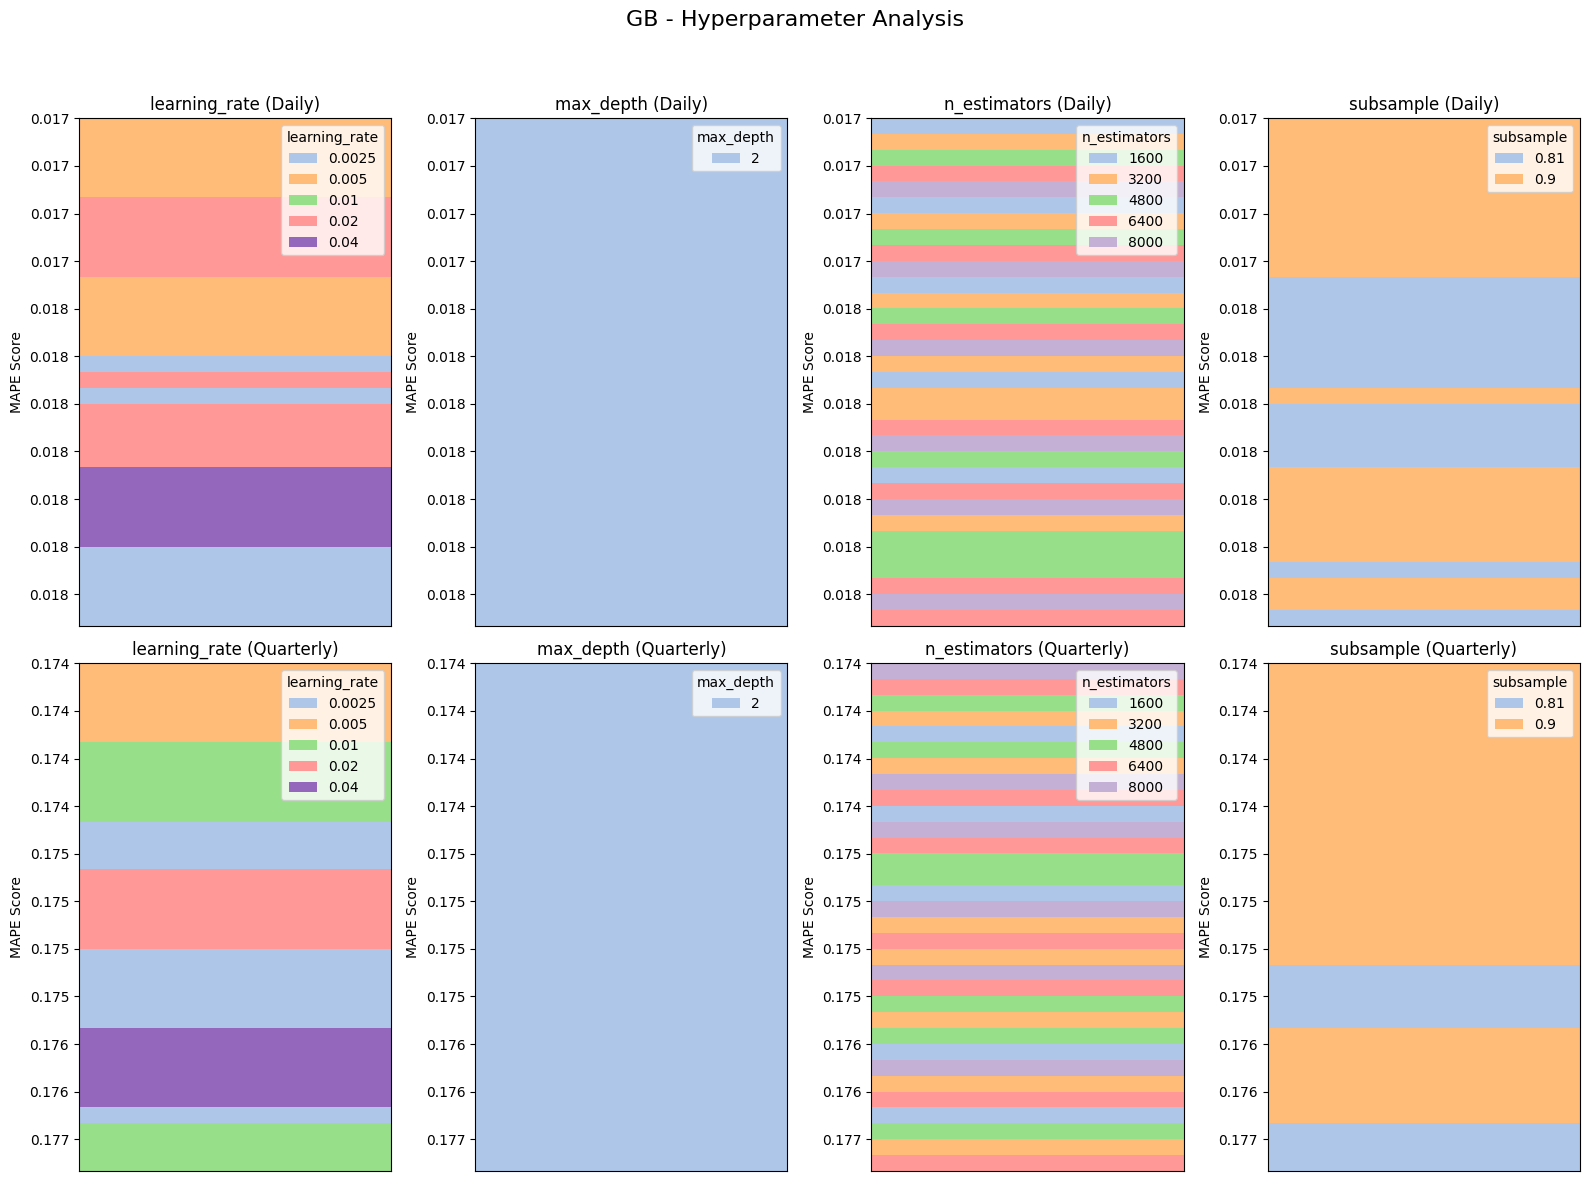

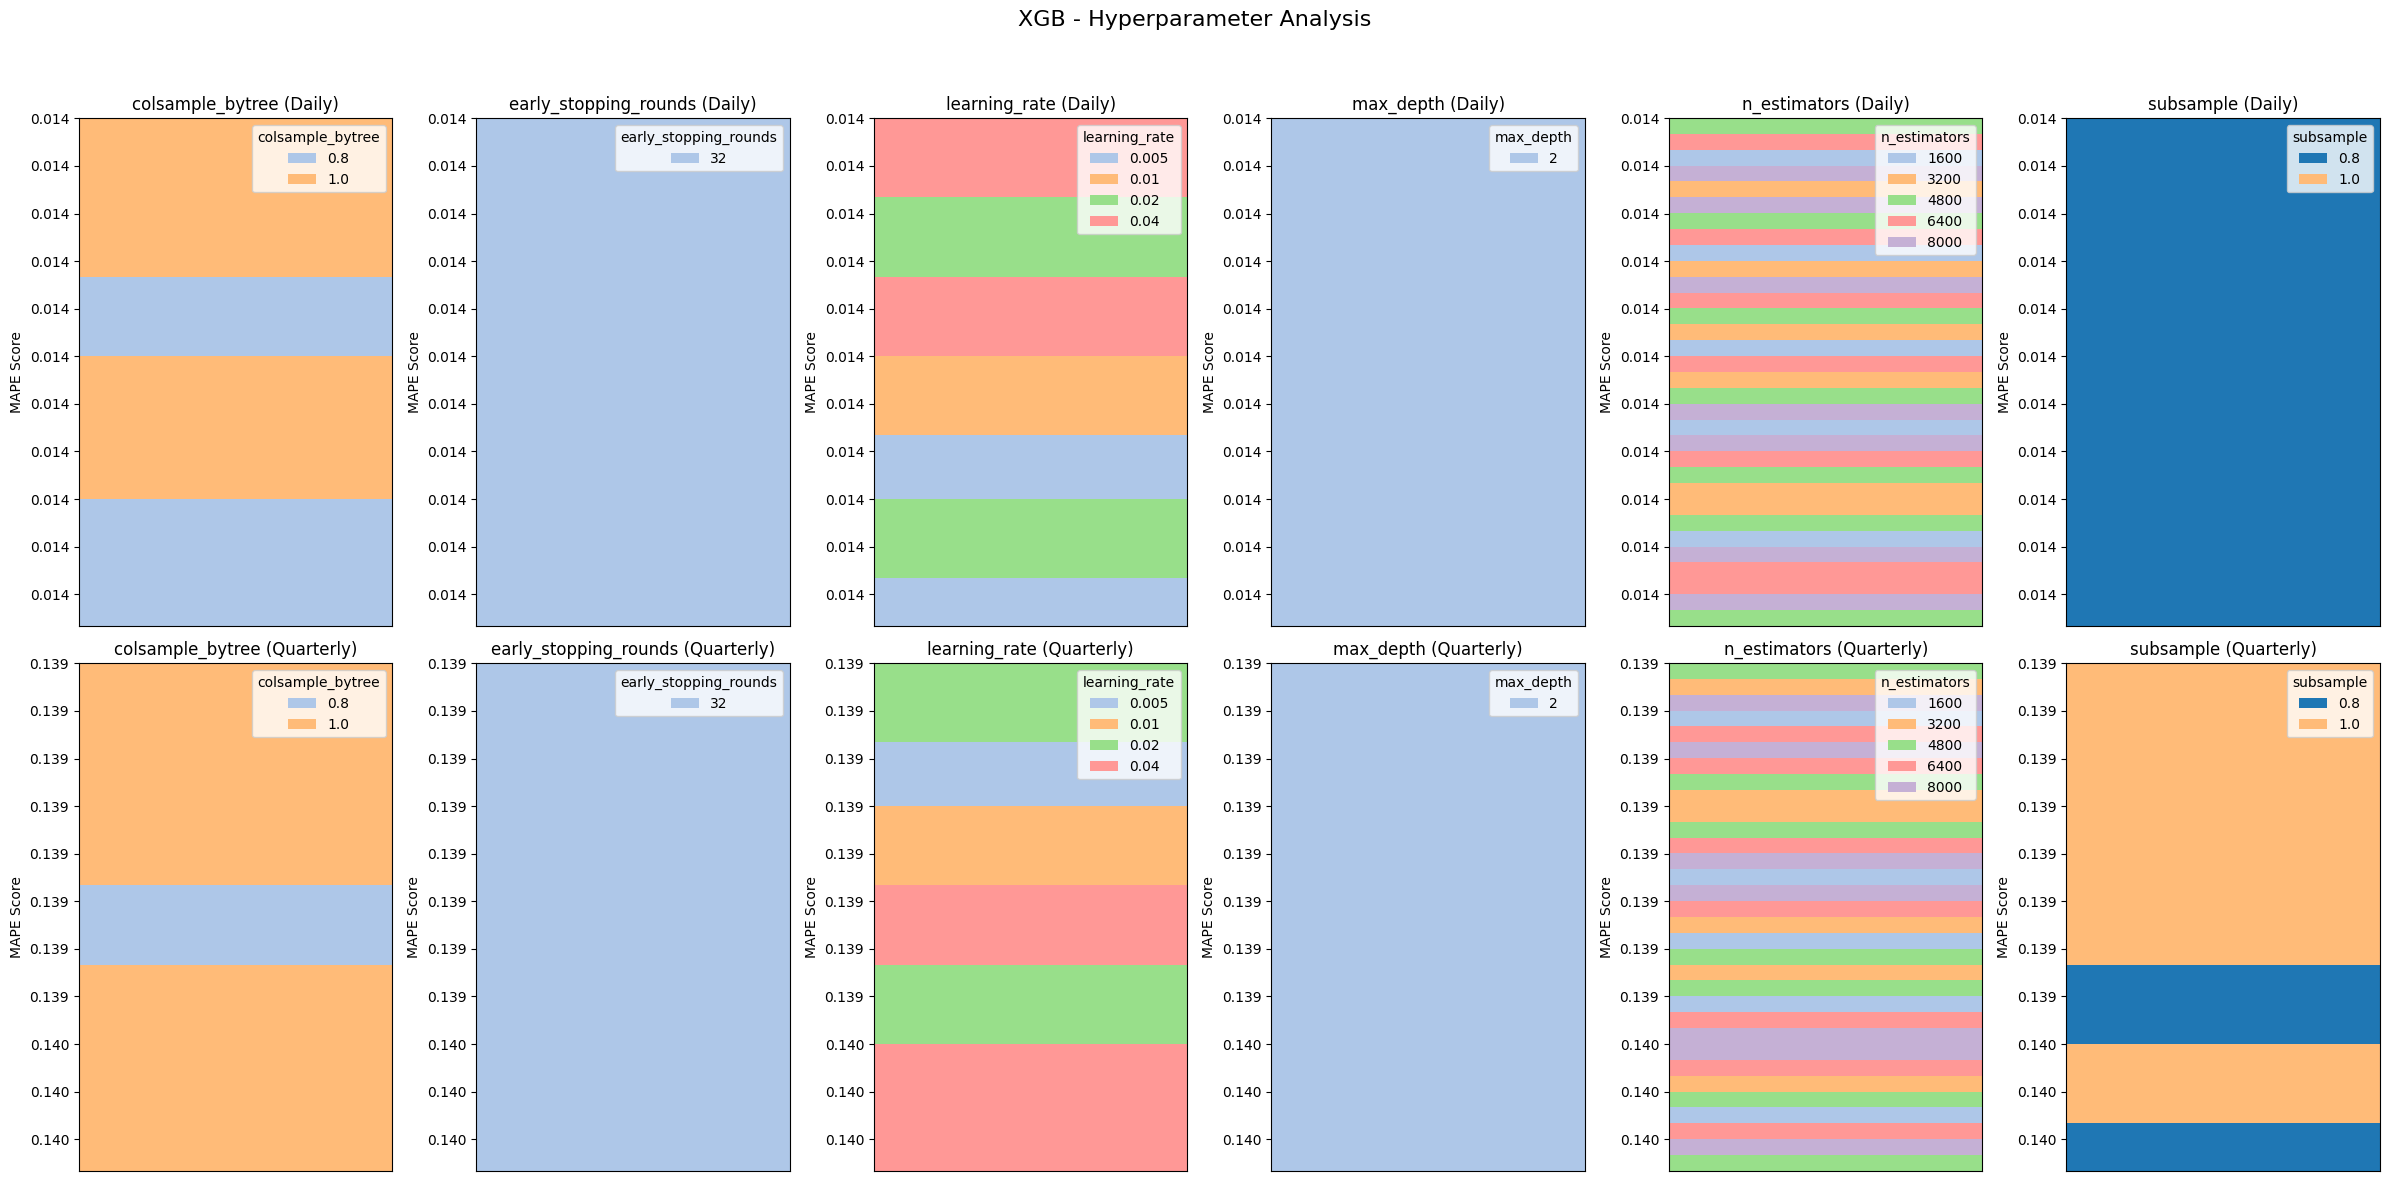

In [72]:
def get_tab_colors():
    cmap1 = plt.cm.tab20
    cmap2 = plt.cm.tab20b
    colors = []
    for i in range(20):
        rgba = cmap1(i)
        colors.append('#{0:02x}{1:02x}{2:02x}'.format(int(rgba[0]*255),
                                                       int(rgba[1]*255),
                                                       int(rgba[2]*255)))
    for i in range(20):
        rgba = cmap2(i)
        colors.append('#{0:02x}{1:02x}{2:02x}'.format(int(rgba[0]*255),
                                                       int(rgba[1]*255),
                                                       int(rgba[2]*255)))
    return colors

PALETTE = get_tab_colors()

# Helper function to safely sort unique values.
def safe_sort_unique(vals):
    try:
        return sorted(vals)
    except TypeError:
        numeric_items = []
        non_numeric_items = []
        for x in vals:
            try:
                numeric_items.append((float(x), x))
            except:
                non_numeric_items.append(x)
        numeric_items.sort(key=lambda pair: pair[0])
        non_numeric_items.sort(key=lambda x: str(x))
        return [pair[1] for pair in numeric_items] + non_numeric_items

# Fixed columns that are not considered hyperparameters.
fixed_cols = set(["model_name", "window_size", "test_ratio", "start_date", "end_date",
                   "test_data_values_list", "test_data_model_predictions_list",
                   "MSE_score", "MAPE_score", "R^2_score", "range"])

# Helper function to map a DataFrame column to an integer code based on the provided order.
def create_stripe(df, col, order):
    n = len(df)
    codes = df[col].map(lambda x: order.index(x) if x in order else -1).values.reshape(n, 1)
    return codes

# Loop over each model in results_dict.
for model in results_dict:
    df_model = results_dict[model].copy()

    # Identify hyperparameter columns by excluding fixed columns.
    hyperparam_cols = [col for col in df_model.columns if col not in fixed_cols]
    if not hyperparam_cols:
        print(f"[WARNING] No hyperparameter columns detected for {model}. Skipping plot.")
        continue

    # Split into daily (range "d") and quarterly (range "q") results sorted by MAPE_score.
    daily_df = df_model[df_model["range"] == "d"].sort_values("MAPE_score", ascending=True).reset_index(drop=True)
    quarterly_df = df_model[df_model["range"] == "q"].sort_values("MAPE_score", ascending=True).reset_index(drop=True)

    n_hp = len(hyperparam_cols)
    # Create a grid with 2 rows (daily and quarterly) and n_hp columns (one per hyperparameter).
    fig, axs = plt.subplots(2, n_hp, figsize=(4 * n_hp, 6 * 2), squeeze=False)

    # Loop over hyperparameter columns.
    for i, hp in enumerate(hyperparam_cols):
        # Determine the unique values for the hyperparameter from both daily and quarterly data.
        unique_vals = safe_sort_unique(np.concatenate((daily_df[hp].dropna().unique(), quarterly_df[hp].dropna().unique())))
        colors_map = {val: PALETTE[j] for j, val in enumerate(unique_vals)}
        cmap_hp = ListedColormap([colors_map[val] for val in unique_vals])
        
        # Create stripe images for daily and quarterly data.
        daily_stripe = create_stripe(daily_df, hp, unique_vals)
        quarterly_stripe = create_stripe(quarterly_df, hp, unique_vals)
        
        # Get the axes for daily (top row) and quarterly (bottom row) for column i.
        ax_daily = axs[0, i]
        ax_quarterly = axs[1, i]
        
        # Plot daily stripe.
        n_d = daily_stripe.shape[0]
        ax_daily.imshow(daily_stripe, aspect="auto", interpolation="none",
                        cmap=cmap_hp, extent=[0, 1, 0, n_d], origin="lower")
        ax_daily.set_title(f"{hp} (Daily)")
        ax_daily.set_xticks([])
        tick_int_d = max(1, n_d // 10)
        ticks_d = np.arange(0, n_d, tick_int_d)
        tick_labels_d = [f"{daily_df.iloc[j]['MAPE_score']:.3f}" for j in ticks_d]
        ax_daily.set_yticks(ticks_d)
        ax_daily.set_yticklabels(tick_labels_d)
        ax_daily.set_ylabel("MAPE Score")
        ax_daily.invert_yaxis()
        
        legend_elements = [Patch(facecolor=colors_map[val], label=str(val)) for val in unique_vals][::2]
        ax_daily.legend(handles=legend_elements, title=hp, loc="upper right")
        
        # Plot quarterly stripe.
        n_q = quarterly_stripe.shape[0]
        ax_quarterly.imshow(quarterly_stripe, aspect="auto", interpolation="none",
                            cmap=cmap_hp, extent=[0, 1, 0, n_q], origin="lower")
        ax_quarterly.set_title(f"{hp} (Quarterly)")
        ax_quarterly.set_xticks([])
        tick_int_q = max(1, n_q // 10)
        ticks_q = np.arange(0, n_q, tick_int_q)
        tick_labels_q = [f"{quarterly_df.iloc[j]['MAPE_score']:.3f}" for j in ticks_q]
        ax_quarterly.set_yticks(ticks_q)
        ax_quarterly.set_yticklabels(tick_labels_q)
        ax_quarterly.set_ylabel("MAPE Score")
        ax_quarterly.invert_yaxis()
        
        # For each hyperparameter, add a single legend to the bottom subplot.
        legend_elements = [Patch(facecolor=colors_map[val], label=str(val)) for val in unique_vals][::2]
        ax_quarterly.legend(handles=legend_elements, title=hp, loc="upper right")
    
    plt.suptitle(f"{model} - Hyperparameter Analysis", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [ ]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)  # disable scientific notation

# Dictionary mapping abbreviations to interpretable full names
COLUMN_NAME_MAPPING = {
    'Adj Close': 'Adjusted Closing Price',
    'Close': 'Closing Price',
    'High': 'Daily High Price',
    'Low': 'Daily Low Price',
    'Open': 'Opening Price',
    'Volume': 'Trading Volume',
    'SMA5': '5-Day Simple Moving Average',
    'SMA50': '50-Day Simple Moving Average',
    'SMA200': '200-Day Simple Moving Average',
    'MACDLine': 'MACD Line',
    'MACDSignal': 'MACD Signal Line',
    'MACDHist': 'MACD Histogram',
    'RSI14': '14-Day Relative Strength Index',
    'BBupper': 'Bollinger Bands Upper',
    'BBlower': 'Bollinger Bands Lower',
    'ROC12': '12-Day Rate of Change',
    'PPO': 'Percentage Price Oscillator',
    'MOM5': '5-Day Momentum',
    'StochK': 'Stochastic %K',
    'StochD': 'Stochastic %D',
    'WillR': 'Williams %R',
    'AccDist': 'Accumulation/Distribution Line',
    'PlusDI14': '14-Day Positive Directional Indicator',
    'TR': 'True Range',
    'SlowStochD': 'Slow Stochastic %D',
    'ChaikinOsc': 'Chaikin Oscillator',
    'ADX14': 'Average Directional Index',
    'ATR14': 'Average True Range',
    '^GSPC': 'S&P 500 Index',
    '^IXIC': 'NASDAQ Composite Index',
    '^DJI': 'Dow Jones Industrial Average',
    '^VIX': 'Volatility Index (VIX)',
    'CL=F': 'Crude Oil Futures',
    'GC=F': 'Gold Futures',
    'SI=F': 'Silver Futures',
    '^TNX': '10-Year Treasury Yield',
    'DX-Y.NYB': 'US Dollar Index',
    'FedFundsRate': 'Federal Funds Rate',
    'GDP': 'Gross Domestic Product',
    'Real_GDP': 'Real Gross Domestic Product',
    'Real_GDP_Per_Capita': 'Real GDP Per Capita',
    'GDP_Deflator': 'GDP Deflator',
    'Unemployment': 'Unemployment Rate',
    'M2_Money_Supply': 'M2 Money Supply',
    'CPI': 'Consumer Price Index',
    'Fed_Funds_Rate': 'Federal Funds Rate',
    'Consumer_Sentiment': 'Consumer Sentiment Index',
    'Retail_Sales': 'Retail Sales',
    'Industrial_Production': 'Industrial Production Index',
    'Housing_Starts': 'Housing Starts',
    'Corp_Profits': 'Corporate Profits',
    'PCE': 'Personal Consumption Expenditures',
    'Business_Investment': 'Business Investment',
    'Labor_Force_Participation': 'Labor Force Participation Rate',
    'Job_Openings_Rate': 'Job Openings Rate',
    'Real_Weekly_Earnings': 'Real Weekly Earnings',
    'Private_Job_Growth': 'Private Sector Job Growth',
    'CPI_BLS': 'Consumer Price Index (BLS)',
    'Hourly_Earnings': 'Average Hourly Earnings',
    'revenue': 'Revenue',
    'gross_profit': 'Gross Profit',
    'operating_income': 'Operating Income',
    'net_income': 'Net Income',
    'eps_diluted': 'Diluted Earnings Per Share',
    'fcf': 'Free Cash Flow',
    'cf_cfo': 'Cash Flow from Operations',
    'capex': 'Capital Expenditures',
    'total_assets': 'Total Assets',
    'total_liabilities': 'Total Liabilities',
    'total_equity': 'Total Shareholder Equity',
    'debt_to_equity': 'Debt-to-Equity Ratio',
    'cash_and_equiv': 'Cash and Equivalents',
    'working_capital': 'Working Capital',
    'roa': 'Return on Assets',
    'roe': 'Return on Equity',
    'operating_margin': 'Operating Margin',
    'receivables': 'Accounts Receivable',
    'inventories': 'Inventories',
    'ppe_net': 'Property, Plant & Equipment (Net)',
    'cff_debt_net': 'Net Debt Cash Flow from Financing',
    'cogs': 'Cost of Goods Sold',
    'sga': 'Selling, General & Administrative Expenses',
    'revenue_growth': 'Revenue Growth Rate',
    'y': 'Target Variable (Stock Price)'
}

def summary_statistics(df):
    """
    Compute summary statistics for each numeric column in the DataFrame with interpretable labels.
    Includes: Count, Mean, Median, Std Deviation, Variance, Min, 2.5th Percentile, 
    25th Percentile, 50th Percentile, 75th Percentile, 97.5th Percentile, Max.
    """
    numeric_df = df.select_dtypes(include=['number']).rename(columns=COLUMN_NAME_MAPPING)

    desc = numeric_df.describe(percentiles=[.025, .25, .5, .75, .975]).T
    desc["median"] = numeric_df.median()

    ordered_cols = ["count", "mean", "median", "std", 
                    "min", "2.5%", "25%", "50%", "75%", "97.5%", "max"]

    return desc[ordered_cols]

# Example usage:
print("----- Daily Data Summary Statistics -----")
for ticker, df in daily_data_dict.items():
    print(f"\nTicker: {ticker}")
    summary_df = summary_statistics(df)
    display(summary_df)
    break

print("\n----- Quarterly Data Summary Statistics -----")
for ticker, df in quarterly_data_dict.items():
    print(f"\nTicker: {ticker}")
    summary_df = summary_statistics(df)
    display(summary_df)
    break

----- Daily Data Summary Statistics -----

Ticker: AAPL


,count,mean,median,std,min,2.5%,25%,50%,75%,97.5%,max
Adjusted Closing Price,2516.0000,94.1799,64.6082,65.6651,20.6745,22.1635,35.3434,64.6082,150.7478,226.8844,258.7355
Closing Price,2516.0000,96.3640,66.6613,65.2552,22.5850,24.2847,37.6394,66.6613,152.7725,227.4850,259.0200
Daily High Price,2516.0000,97.2997,67.2812,65.8493,22.9175,24.5519,38.0400,67.2812,154.5650,229.4012,260.1000
Daily Low Price,2516.0000,95.3239,65.8075,64.5678,22.3675,24.1072,37.2956,65.8075,150.8125,225.1950,257.6300
Opening Price,2516.0000,96.2756,66.5500,65.1750,22.5000,24.3044,37.6069,66.5500,152.5725,227.3950,258.1900
Trading Volume,2516.0000,117086723.3307,100364650.0000,68399571.9998,23234700.0000,39950525.0000,71056100.0000,100364650.0000,142621625.0000,298016600.0000,648825200.0000
5-Day Simple Moving Average,2516.0000,93.9989,64.1877,65.5196,21.0352,22.1964,35.4138,64.1877,150.3673,226.4859,256.2323
50-Day Simple Moving Average,2516.0000,92.0593,64.2848,64.0967,21.9008,22.6998,34.7420,64.2848,148.6838,222.2639,237.2716
200-Day Simple Moving Average,2516.0000,86.1398,52.8863,60.3711,21.3683,23.3224,30.1539,52.8863,149.4462,196.7484,212.8294
MACD Line,2516.0000,0.6058,0.3876,2.0693,-6.5111,-3.6612,-0.3281,0.3876,1.4957,5.5865,8.9254



----- Quarterly Data Summary Statistics -----

Ticker: AAPL


,count,mean,median,std,min,2.5%,25%,50%,75%,97.5%,max
Closing Price,39.0000,92.3405,61.7108,64.9588,21.8783,23.7172,34.8389,61.7108,137.6246,211.0432,232.4883
Daily High Price,39.0000,103.3326,73.4925,69.3909,27.6050,28.0729,40.1987,73.4925,170.5750,221.0515,237.2300
Daily Low Price,39.0000,81.7094,53.1525,56.1244,22.3675,22.9684,35.2575,53.1525,132.3500,169.8655,196.0000
Gross Domestic Product,39.0000,22505.1624,21684.5510,3556.5489,18063.5290,18268.9712,19565.6190,21684.5510,25510.6410,29034.6240,29374.9140
Real Gross Domestic Product,39.0000,20753.9188,20602.2750,1433.2539,18666.6210,18776.4619,19452.6460,20602.2750,21939.8050,23232.7254,23400.2940
Real GDP Per Capita,39.0000,62721.8205,62385.0000,3387.4640,57440.0000,58086.9500,59615.0000,62385.0000,65804.5000,68338.8000,68696.0000
GDP Deflator,39.0000,107.8194,104.5160,9.5198,96.7690,97.2972,99.9060,104.5160,116.4250,124.9724,125.5320
Unemployment Rate,39.0000,4.5923,4.1000,1.4236,3.5000,3.5000,3.7500,4.1000,5.0000,7.9600,11.0000
M2 Money Supply,39.0000,16875.6718,15348.0000,3666.0295,11903.7000,12000.5050,13640.7500,15348.0000,20829.4500,21646.4150,21720.8000
Consumer Price Index,39.0000,266.4248,257.0420,25.9833,235.9760,237.4219,245.2990,257.0420,291.2695,313.2170,314.8510


In [5]:
daily_data_dict["AAPL"].columns

Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'SMA5', 'SMA50',
       'SMA200', 'MACDLine', 'MACDSignal', 'MACDHist', 'RSI14', 'BBupper',
       'BBlower', 'ROC12', 'PPO', 'MOM5', 'StochK', 'StochD', 'WillR',
       'AccDist', 'PlusDI14', 'TR', 'SlowStochD', 'ChaikinOsc', 'ADX14',
       'ATR14', '^GSPC', '^IXIC', '^DJI', '^VIX', 'CL=F', 'GC=F', 'SI=F',
       '^TNX', 'DX-Y.NYB', 'FedFundsRate', 'y'],
      dtype='object')

In [6]:
quarterly_data_dict["AAPL"].columns

Index(['Close', 'High', 'Low', 'GDP', 'Real_GDP', 'Real_GDP_Per_Capita',
       'GDP_Deflator', 'Unemployment', 'M2_Money_Supply', 'CPI',
       'Fed_Funds_Rate', 'Consumer_Sentiment', 'Retail_Sales',
       'Industrial_Production', 'Housing_Starts', 'Corp_Profits', 'PCE',
       'Business_Investment', 'Labor_Force_Participation', 'Job_Openings_Rate',
       'Real_Weekly_Earnings', 'Private_Job_Growth', 'CPI_BLS',
       'Hourly_Earnings', 'revenue', 'gross_profit', 'operating_income',
       'net_income', 'eps_diluted', 'fcf', 'cf_cfo', 'capex', 'total_assets',
       'total_liabilities', 'total_equity', 'debt_to_equity', 'cash_and_equiv',
       'working_capital', 'roa', 'roe', 'operating_margin', 'receivables',
       'inventories', 'ppe_net', 'cff_debt_net', 'cogs', 'sga',
       'revenue_growth', 'y'],
      dtype='object')

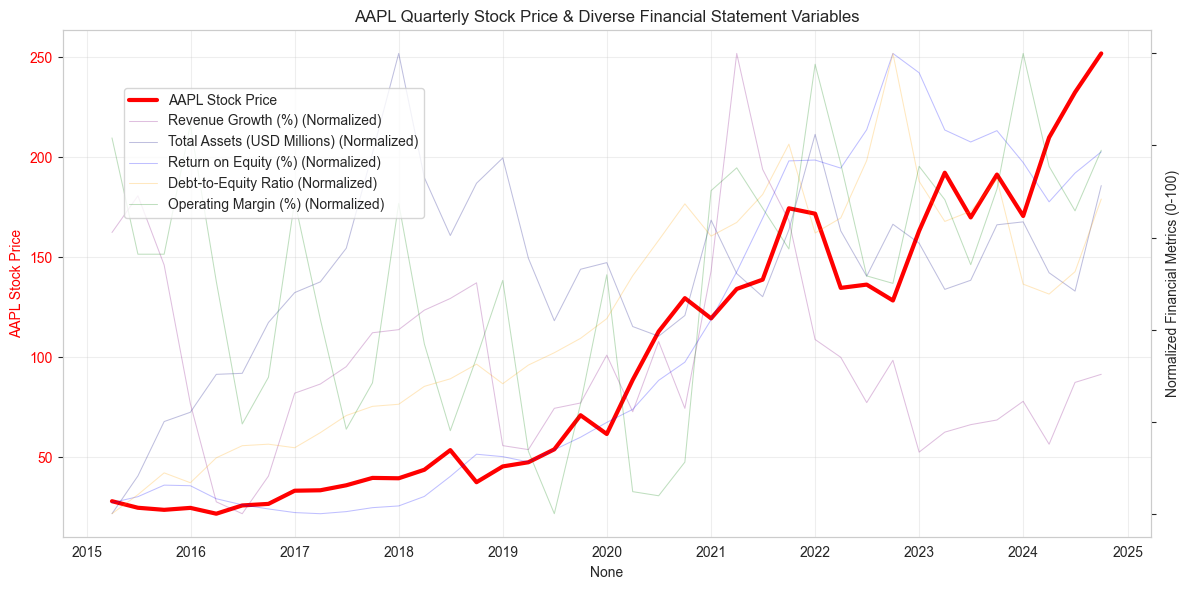

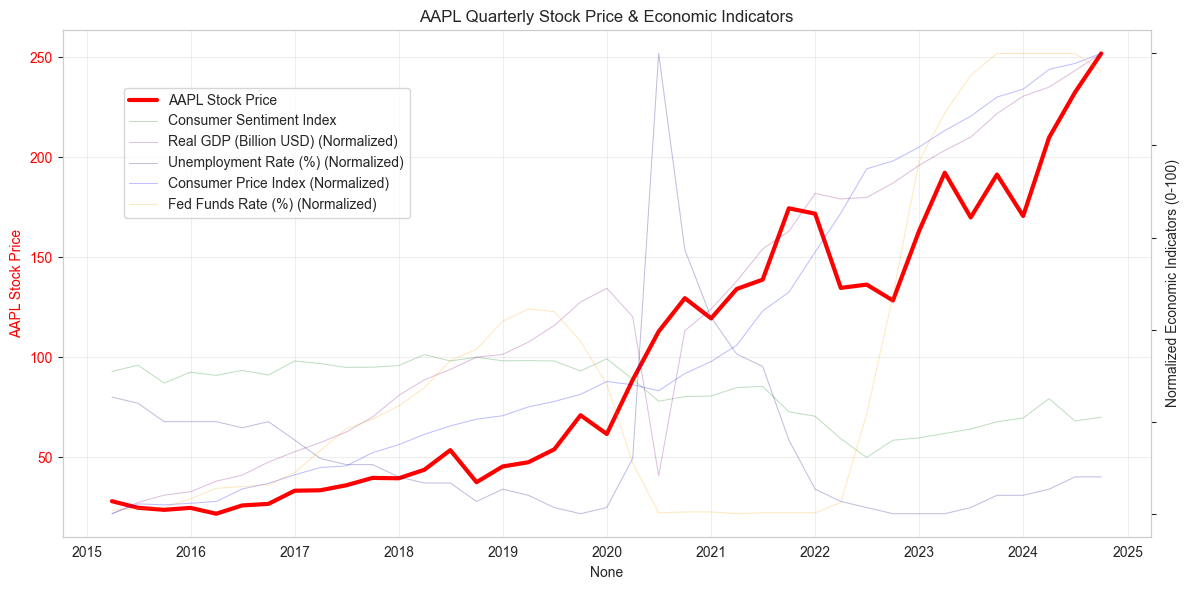

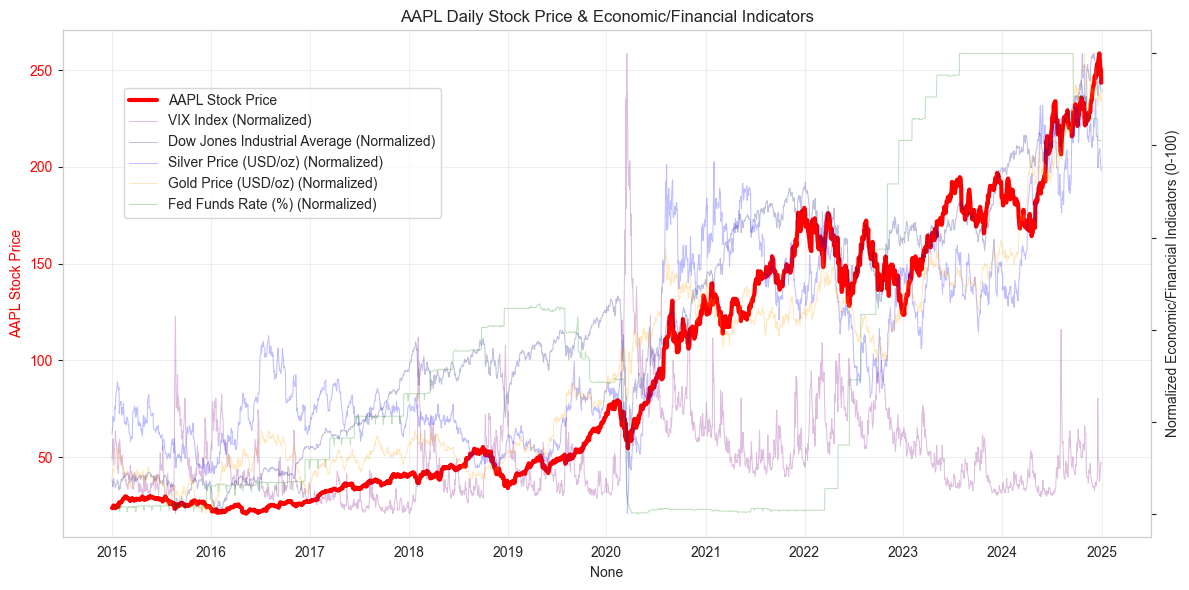

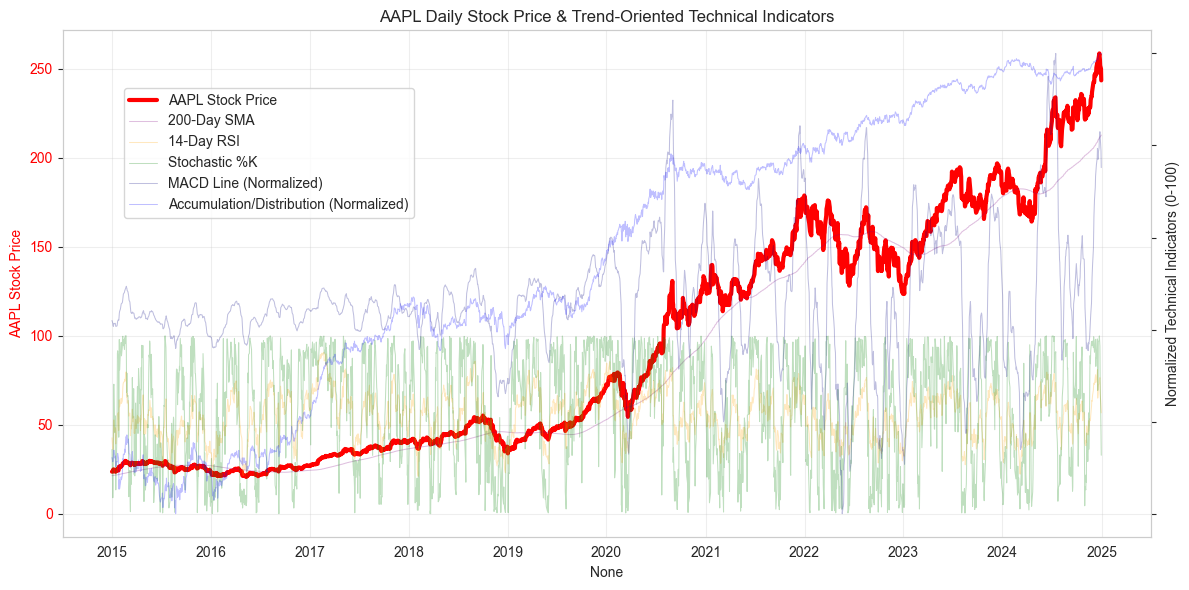

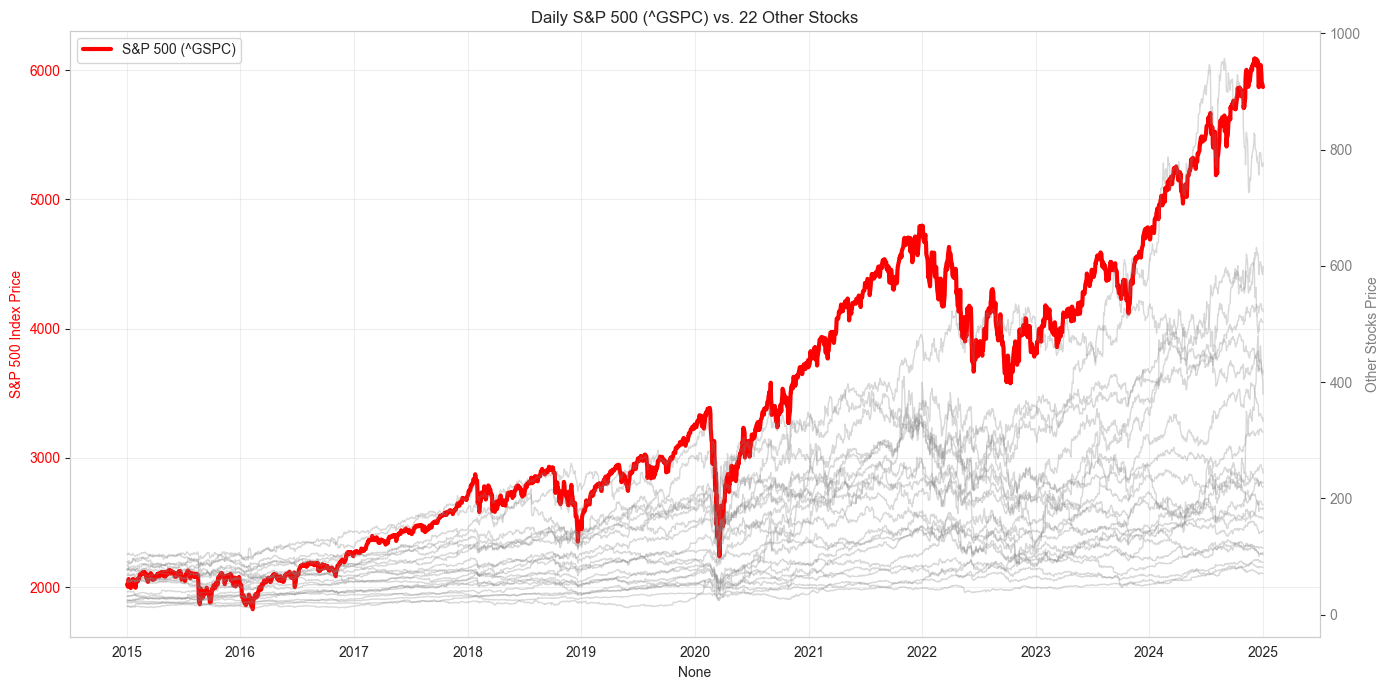

In [7]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

# --- Helper Functions ---

def convert_quarter_index(df):
    """
    Convert the DataFrame index to quarter–end timestamps.
    """
    try:
        return pd.PeriodIndex(df.index, freq='Q').to_timestamp(how='E')
    except Exception:
        return pd.to_datetime(df.index)

def ensure_numeric(series):
    """
    Ensure that the series is numeric; convert if needed.
    """
    if not np.issubdtype(series.dtype, np.number):
        return pd.to_numeric(series, errors='coerce')
    return series

def min_max_normalize(series):
    """
    Normalize the series using min–max scaling to the range [0, 100].
    """
    series = ensure_numeric(series)
    rng = series.max() - series.min()
    if rng == 0:
        return series * 0 + 100
    return (series - series.min()) / rng * 100

def in_same_order(main_series, other_series, threshold=0.5):
    """
    Check if the mean of other_series is within threshold (50%) of the main_series' mean.
    """
    main_mean = ensure_numeric(main_series).mean()
    other_mean = ensure_numeric(other_series).mean()
    return abs(other_mean - main_mean) / main_mean <= threshold

def combine_legends(ax1, ax2):
    """
    Combine legend handles and labels from two axes.
    """
    handles1, labels1 = ax1.get_legend_handles_labels()
    if ax2 and ax2.get_visible():
        handles2, labels2 = ax2.get_legend_handles_labels()
    else:
        handles2, labels2 = [], []
    return handles1 + handles2, labels1 + labels2

# --- Plotting Functions ---

def plot_quarterly_financial_statements():
    """
    Plot AAPL quarterly stock price (y) with 5 diverse financial statement variables.
    The main red line (linewidth=3) is on the primary axis (with grid alpha=0.33).
    Additional lines use custom colors (purple, navy, blue, orange, green) with linewidth=0.75 and alpha=0.25.
    If scales differ, min–max normalization is applied.
    A single combined legend is displayed.
    """
    df = quarterly_data_dict["AAPL"].copy()
    df.index = pd.to_datetime(convert_quarter_index(df)).normalize()

    candidate_vars = ["revenue_growth", "total_assets", "roe", "debt_to_equity", "operating_margin"]
    available_vars = [var for var in candidate_vars if var in df.columns][:5]
    other_colors = ["purple", "navy", "blue", "orange", "green"][:len(available_vars)]

    fig, ax1 = plt.subplots(figsize=(12, 6))
    sns.lineplot(x=df.index, y=df["y"], ax=ax1, color="red", 
                 label="AAPL Stock Price", linewidth=3)
    ax1.set_ylabel("AAPL Stock Price", color="red")
    ax1.tick_params(axis="y", labelcolor="red")
    ax1.grid(True, which='both', alpha=0.33)

    ax2 = ax1.twinx()
    ax2.grid(False)
    ax2_used = False
    main_series = ensure_numeric(df["y"])

    label_map = {
        "revenue_growth": "Revenue Growth (%)",
        "total_assets": "Total Assets (USD Millions)",
        "roe": "Return on Equity (%)",
        "debt_to_equity": "Debt-to-Equity Ratio",
        "operating_margin": "Operating Margin (%)"
    }

    for i, var in enumerate(available_vars):
        series = ensure_numeric(df[var])
        color = other_colors[i]
        if in_same_order(main_series, series):
            sns.lineplot(x=df.index, y=series, ax=ax1,
                         label=label_map.get(var, var), linewidth=0.75, alpha=0.25, color=color)
        else:
            norm_series = min_max_normalize(series)
            sns.lineplot(x=df.index, y=norm_series, ax=ax2,
                         label=label_map.get(var, var) + " (Normalized)", linewidth=0.75, alpha=0.25, color=color)
            ax2_used = True
    if ax2_used:
        ax2.set_ylabel("Normalized Financial Metrics (0-100)")
        ax2.set_yticklabels([])
    else:
        ax2.set_visible(False)

    # Remove individual legends then combine them.
    if ax1.get_legend():
        ax1.get_legend().remove()
    if ax2.get_legend():
        ax2.get_legend().remove()
    handles, labels = combine_legends(ax1, ax2)
    plt.title("AAPL Quarterly Stock Price & Diverse Financial Statement Variables")
    plt.legend(handles, labels, loc="upper left", bbox_to_anchor=(0.05, 0.9))
    plt.tight_layout()
    plt.show()

def plot_quarterly_economic_indicators():
    """
    Plot AAPL quarterly stock price with 5 economic indicators.
    Additional lines use custom colors (purple, navy, blue, orange, green) with linewidth=0.75 and alpha=0.25.
    Normalization is applied if needed, and a combined legend is displayed.
    """
    df = quarterly_data_dict["AAPL"].copy()
    df.index = pd.to_datetime(convert_quarter_index(df)).normalize()

    candidate_vars = ["Real_GDP", "Unemployment", "CPI", "Fed_Funds_Rate", "Consumer_Sentiment"]
    available_vars = [var for var in candidate_vars if var in df.columns][:5]
    other_colors = ["purple", "navy", "blue", "orange", "green"][:len(available_vars)]

    fig, ax1 = plt.subplots(figsize=(12, 6))
    sns.lineplot(x=df.index, y=df["y"], ax=ax1, color="red",
                 label="AAPL Stock Price", linewidth=3)
    ax1.set_ylabel("AAPL Stock Price", color="red")
    ax1.tick_params(axis="y", labelcolor="red")
    ax1.grid(True, which='both', alpha=0.33)

    ax2 = ax1.twinx()
    ax2.grid(False)
    ax2_used = False
    main_series = ensure_numeric(df["y"])

    label_map = {
        "Real_GDP": "Real GDP (Billion USD)",
        "Unemployment": "Unemployment Rate (%)",
        "CPI": "Consumer Price Index",
        "Fed_Funds_Rate": "Fed Funds Rate (%)",
        "Consumer_Sentiment": "Consumer Sentiment Index"
    }

    for i, var in enumerate(available_vars):
        series = ensure_numeric(df[var])
        color = other_colors[i]
        if in_same_order(main_series, series):
            sns.lineplot(x=df.index, y=series, ax=ax1,
                         label=label_map.get(var, var), linewidth=0.75, alpha=0.25, color=color)
        else:
            norm_series = min_max_normalize(series)
            sns.lineplot(x=df.index, y=norm_series, ax=ax2,
                         label=label_map.get(var, var) + " (Normalized)", linewidth=0.75, alpha=0.25, color=color)
            ax2_used = True
    if ax2_used:
        ax2.set_ylabel("Normalized Economic Indicators (0-100)")
        ax2.set_yticklabels([])
    else:
        ax2.set_visible(False)

    if ax1.get_legend():
        ax1.get_legend().remove()
    if ax2.get_legend():
        ax2.get_legend().remove()
    handles, labels = combine_legends(ax1, ax2)
    plt.title("AAPL Quarterly Stock Price & Economic Indicators")
    plt.legend(handles, labels, loc="upper left", bbox_to_anchor=(0.05, 0.9))
    plt.tight_layout()
    plt.show()

def plot_daily_economic_indicators():
    """
    Plot AAPL daily stock price with 5 daily economic/financial indicators.
    We include indices and commodity prices (silver then gold) plus Fed Funds Rate.
    Additional lines use custom colors (purple, navy, blue, orange, green) with linewidth=0.75 and alpha=0.25.
    A combined legend is displayed.
    """
    df = daily_data_dict["AAPL"].copy()
    df.index = pd.to_datetime(df.index).normalize()

    # Switch order: silver ("SI=F") comes before gold ("GC=F")
    candidate_vars = ["^VIX", "^DJI", "SI=F", "GC=F", "FedFundsRate"]
    available_vars = [var for var in candidate_vars if var in df.columns][:5]
    other_colors = ["purple", "navy", "blue", "orange", "green"][:len(available_vars)]

    fig, ax1 = plt.subplots(figsize=(12, 6))
    sns.lineplot(x=df.index, y=df["y"], ax=ax1, color="red",
                 label="AAPL Stock Price", linewidth=3)
    ax1.set_ylabel("AAPL Stock Price", color="red")
    ax1.tick_params(axis="y", labelcolor="red")
    ax1.grid(True, which='both', alpha=0.33)

    ax2 = ax1.twinx()
    ax2.grid(False)
    ax2_used = False
    main_series = ensure_numeric(df["y"])

    label_map = {
        "^VIX": "VIX Index",
        "^DJI": "Dow Jones Industrial Average",
        "SI=F": "Silver Price (USD/oz)",
        "GC=F": "Gold Price (USD/oz)",
        "FedFundsRate": "Fed Funds Rate (%)"
    }

    for i, var in enumerate(available_vars):
        series = ensure_numeric(df[var])
        color = other_colors[i]
        if in_same_order(main_series, series):
            sns.lineplot(x=df.index, y=series, ax=ax1,
                         label=label_map.get(var, var), linewidth=0.75, alpha=0.25, color=color)
        else:
            norm_series = min_max_normalize(series)
            sns.lineplot(x=df.index, y=norm_series, ax=ax2,
                         label=label_map.get(var, var) + " (Normalized)", linewidth=0.75, alpha=0.25, color=color)
            ax2_used = True
    if ax2_used:
        ax2.set_ylabel("Normalized Economic/Financial Indicators (0-100)")
        ax2.set_yticklabels([])
    else:
        ax2.set_visible(False)

    if ax1.get_legend():
        ax1.get_legend().remove()
    if ax2.get_legend():
        ax2.get_legend().remove()
    handles, labels = combine_legends(ax1, ax2)
    plt.title("AAPL Daily Stock Price & Economic/Financial Indicators")
    plt.legend(handles, labels, loc="upper left", bbox_to_anchor=(0.05, 0.9))
    plt.tight_layout()
    plt.show()

def plot_daily_technical_indicators():
    """
    Plot AAPL daily stock price with 5 trend-oriented technical indicators.
    Candidate variables are now: SMA200, MACDLine, AccDist, RSI14, and StochK.
    Additional lines use custom colors (purple, navy, blue, orange, green) with linewidth=0.75 and alpha=0.25.
    A combined legend is displayed.
    """
    df = daily_data_dict["AAPL"].copy()
    df.index = pd.to_datetime(df.index).normalize()

    candidate_vars = ["SMA200", "MACDLine", "AccDist", "RSI14", "StochK"]
    available_vars = [var for var in candidate_vars if var in df.columns][:5]
    other_colors = ["purple", "navy", "blue", "orange", "green"][:len(available_vars)]

    fig, ax1 = plt.subplots(figsize=(12, 6))
    sns.lineplot(x=df.index, y=df["y"], ax=ax1, color="red",
                 label="AAPL Stock Price", linewidth=3)
    ax1.set_ylabel("AAPL Stock Price", color="red")
    ax1.tick_params(axis="y", labelcolor="red")
    ax1.grid(True, which='both', alpha=0.33)

    ax2 = ax1.twinx()
    ax2.grid(False)
    ax2_used = False
    main_series = ensure_numeric(df["y"])

    label_map = {
        "SMA200": "200-Day SMA",
        "MACDLine": "MACD Line",
        "AccDist": "Accumulation/Distribution",
        "RSI14": "14-Day RSI",
        "StochK": "Stochastic %K"
    }

    for i, var in enumerate(available_vars):
        series = ensure_numeric(df[var])
        color = other_colors[i]
        if in_same_order(main_series, series):
            sns.lineplot(x=df.index, y=series, ax=ax1,
                         label=label_map.get(var, var), linewidth=0.75, alpha=0.25, color=color)
        else:
            norm_series = min_max_normalize(series)
            sns.lineplot(x=df.index, y=norm_series, ax=ax2,
                         label=label_map.get(var, var) + " (Normalized)", linewidth=0.75, alpha=0.25, color=color)
            ax2_used = True
    if ax2_used:
        ax2.set_ylabel("Normalized Technical Indicators (0-100)")
        ax2.set_yticklabels([])
    else:
        ax2.set_visible(False)

    if ax1.get_legend():
        ax1.get_legend().remove()
    if ax2.get_legend():
        ax2.get_legend().remove()
    handles, labels = combine_legends(ax1, ax2)
    plt.title("AAPL Daily Stock Price & Trend-Oriented Technical Indicators")
    plt.legend(handles, labels, loc="upper left", bbox_to_anchor=(0.05, 0.9))
    plt.tight_layout()
    plt.show()

def plot_sp500_vs_others():
    """
    Plot daily S&P 500 using '^GSPC' (thick red line on primary axis) and
    overlay exactly 22 other stocks (if available) with their original values on the secondary axis.
    This plot has no legend.
    """
    if "^GSPC" not in daily_data_dict:
        print("Data for ^GSPC not available in daily_data_dict.")
        return

    df_sp500 = daily_data_dict["^GSPC"].copy()
    df_sp500.index = pd.to_datetime(df_sp500.index).normalize()

    # Select exactly 22 other stocks (if available).
    other_keys = [k for k in daily_data_dict.keys() if k != "^GSPC"][:22]

    fig, ax1 = plt.subplots(figsize=(14, 7))
    sns.lineplot(x=df_sp500.index, y=ensure_numeric(df_sp500["y"]), ax=ax1,
                 label="S&P 500 (^GSPC)", color="red", linewidth=3)
    ax1.set_ylabel("S&P 500 Index Price", color="red")
    ax1.tick_params(axis="y", labelcolor="red")
    ax1.grid(True, which='both', alpha=0.33)

    ax2 = ax1.twinx()
    ax2.grid(False)
    for key in other_keys:
        df_other = daily_data_dict[key].copy()
        df_other.index = pd.to_datetime(df_other.index).normalize()
        sns.lineplot(x=df_other.index, y=ensure_numeric(df_other["y"]), ax=ax2,
                     color="grey", linewidth=1, alpha=0.3)
    ax2.set_ylabel("Other Stocks Price", color="grey")
    ax2.tick_params(axis="y", labelcolor="grey")

    plt.title("Daily S&P 500 (^GSPC) vs. 22 Other Stocks")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# --- Call the Plot Functions ---

plot_quarterly_financial_statements()
plot_quarterly_economic_indicators()
plot_daily_economic_indicators()
plot_daily_technical_indicators()
plot_sp500_vs_others()
